In [94]:
from config import api_key
from alpha_vantage.timeseries import TimeSeries
import os
import pandas as pd
import numpy as np
%matplotlib inline

In [16]:
import requests

In [45]:
resp_json.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [70]:
def get_daily_symbol(symbol):
    params = dict(function='TIME_SERIES_DAILY',symbol='T',apikey=api_key,outputsize='full')
    resp = requests.get('https://www.alphavantage.co/query', params=params)
    resp_json = resp.json()
    df = pd.DataFrame.from_dict(resp_json['Time Series (Daily)'], orient='index', dtype='float')
    df.columns = [c[c.find(' ')+1:] for c in df]
    df.index = pd.to_datetime(df.index)
    meta = resp_json['Meta Data']
    return df, meta

In [71]:
df, meta = get_daily_symbol('F')

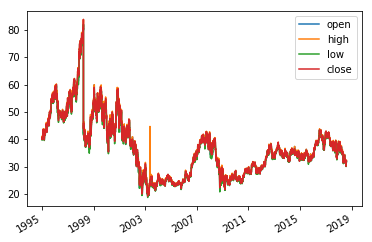

In [73]:
df.drop('volume',1).plot()

In [76]:
html_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',header=0)
sp500 = html_tables[0]

In [80]:
sp500['GICS Sector'].value_counts()

Consumer Discretionary        80
Information Technology        74
Financials                    69
Industrials                   67
Health Care                   62
Consumer Staples              33
Real Estate                   33
Energy                        31
Utilities                     29
Materials                     24
Telecommunication Services     3
Name: GICS Sector, dtype: int64

In [84]:
sp500[sp500['GICS Sector']=='Energy']

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Location,Date first added[3][4],CIK,Founded
42,APC,Anadarko Petroleum Corp,reports,Energy,Oil & Gas Exploration & Production,"The Woodlands, Texas",1997-07-28,773910,1959
44,ANDV,Andeavor,reports,Energy,Oil & Gas Refining & Marketing,"San Antonio, Texas",2007-09-27,50104,1968
49,APA,Apache Corporation,reports,Energy,Oil & Gas Exploration & Production,"Houston, Texas",1997-07-28,6769,1954
64,BHGE,"Baker Hughes, a GE Company",reports,Energy,Oil & Gas Equipment & Services,"Houston, Texas",NaN,1701605,2017
88,COG,Cabot Oil & Gas,reports,Energy,Oil & Gas Exploration & Production,"Houston, Texas",2008-06-23,858470,NaN
107,CVX,Chevron Corp.,reports,Energy,Integrated Oil & Gas,"San Ramon, California",NaN,93410,1879
112,XEC,Cimarex Energy,reports,Energy,Oil & Gas Exploration & Production,"Denver, Colorado",2014-06-21,1168054,NaN
128,CXO,Concho Resources,reports,Energy,Oil & Gas Exploration & Production,"Midland, Texas",2016-02-22,1358071,NaN
129,COP,ConocoPhillips,reports,Energy,Oil & Gas Exploration & Production,"Houston, Texas",NaN,1163165,2002
148,DVN,Devon Energy Corp.,reports,Energy,Oil & Gas Exploration & Production,"Oklahoma City, Oklahoma",2000-08-30,1090012,NaN


In [85]:
from geopy.geocoders import Nominatim

In [86]:
geolocator = Nominatim(user_agent="sp500")

In [115]:
def get_latlong(x): 
    try:
        location = geolocator.geocode(x)
        return (location.latitude, location.longitude)
    except Exception as e:
        print(x)
        return np.nan

In [96]:
import dask.dataframe as dd
from dask.multiprocessing import get

In [116]:
sp500['latlong'] = sp500.Location.apply(get_latlong)

Arlington, Virginia[5]
Marlborough, Massachusetts[6]
Tulsa, Oklahoma[7]


In [117]:
sp500

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Location,Date first added[3][4],CIK,Founded,latlong
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902,"(44.9504037, -93.1015026)"
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,"(42.325578, -87.8411818)"
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),"(42.325578, -87.8411818)"
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,"(42.5750946, -70.9300507)"
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,"(53.3497645, -6.2602732)"
5,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877,2008,"(34.019657, -118.487549)"
6,ADBE,Adobe Systems Inc,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982,"(9.9327612, -84.0665224)"
7,AMD,Advanced Micro Devices Inc,reports,Information Technology,Semiconductors,"Sunnyvale, California",2017-03-20,2488,1969,"(37.3688301, -122.0363496)"
8,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,1158449,1932,"(37.274532, -79.9602096795782)"
9,AES,AES Corp,reports,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,874761,1981,"(38.8903961, -77.0841585)"


In [136]:
sp500.to_pickle('sp500.pkl')

In [126]:
import folium
from folium.plugins import FastMarkerCluster

In [133]:
m = folium.Map()

In [135]:
m.add_child(FastMarkerCluster(data=sp500.latlong.dropna()))

In [139]:
import sqlalchemy as sa

In [140]:
con = sa.create_engine('sqlite:///edgar_htm_idx.db').connect()

In [180]:
df_t = pd.read_sql('select * from idx where conm=="FORD MOTOR CO" and type=="10-Q"', con)

In [182]:
df_t.path.sample(5).iloc[0]

'https://www.sec.gov/Archives/edgar/data/37996/0000037996-13-000055-index.htm'

In [175]:
df_t.query("type=='10-K'").path.iloc[0]

'https://www.sec.gov/Archives/edgar/data/861439/0000912057-94-000263-index.htm'

In [158]:
from selenium.webdriver.chrome.options import Options

In [159]:
import csv
import random
import time

from selenium import webdriver

with open('log.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)

    with open('sample.csv', newline='') as infile:
        records = csv.reader(infile)

        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
            chrome_options = Options()
            chrome_options.add_argument('--headless')
            chrome_options.add_argument('--no-sandbox')
            chrome_options.add_argument('--disable-dev-shm-usage')
            driver = webdriver.Chrome('/usr/local/bin/chromedriver',chrome_options=chrome_options)

            try:
                driver.get(r[5])
                time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]

            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']

            driver.quit()

            logwriter.writerow(log_row)

Start fetching URL to AMERICAN INTERNATIONAL GROUP INC 10-Q filed on 05may2014 ...
Success! 2018-08-05 01:25:22  -->  2018-08-05 01:25:28 

Start fetching URL to AMERICAN INTERNATIONAL GROUP INC 10-Q filed on 03nov2016 ...
Success! 2018-08-05 01:25:28  -->  2018-08-05 01:25:33 

Start fetching URL to AMERICAN INTERNATIONAL GROUP INC 10-Q filed on 10may2007 ...
Success! 2018-08-05 01:25:33  -->  2018-08-05 01:25:41 

Start fetching URL to AMERICAN INTERNATIONAL GROUP INC 10-Q filed on 10may2006 ...
Success! 2018-08-05 01:25:41  -->  2018-08-05 01:25:48 

Start fetching URL to AMERICAN INTERNATIONAL GROUP INC 10-Q filed on 05may2011 ...
Success! 2018-08-05 01:25:48  -->  2018-08-05 01:25:54 



In [167]:
df = pd.read_csv('log.csv')

In [168]:
df

,13780110,5272,AMERICAN INTERNATIONAL GROUP INC,10-Q,05may2014,https://www.sec.gov/Archives/edgar/data/5272/0000005272-14-000007-index.htm,2018-08-05 01:25:22,2018-08-05 01:25:28,2014-05-05,2014-03-31,https://www.sec.gov/Archives/edgar/data/5272/000000527214000007/maindocument001.htm
0,16212215,5272,AMERICAN INTERNATIONAL GROUP INC,10-Q,03nov2016,https://www.sec.gov/Archives/edgar/data/5272/0...,2018-08-05 01:25:28,2018-08-05 01:25:33,2016-11-03,2016-09-30,https://www.sec.gov/Archives/edgar/data/5272/0...
1,6772655,5272,AMERICAN INTERNATIONAL GROUP INC,10-Q,10may2007,https://www.sec.gov/Archives/edgar/data/5272/0...,2018-08-05 01:25:33,2018-08-05 01:25:41,2007-05-10,2007-03-31,https://www.sec.gov/Archives/edgar/data/5272/0...
2,5671285,5272,AMERICAN INTERNATIONAL GROUP INC,10-Q,10may2006,https://www.sec.gov/Archives/edgar/data/5272/0...,2018-08-05 01:25:41,2018-08-05 01:25:48,2006-05-10,2006-03-31,https://www.sec.gov/Archives/edgar/data/5272/0...
3,10831058,5272,AMERICAN INTERNATIONAL GROUP INC,10-Q,05may2011,https://www.sec.gov/Archives/edgar/data/5272/0...,2018-08-05 01:25:48,2018-08-05 01:25:54,2011-05-05,2011-03-31,https://www.sec.gov/Archives/edgar/data/5272/0...
